# Description

For defining functional groups and reaction mechanisms for polymerization

# Core Imports

In [1]:
# Custom Imports
from polysaccharide.extratypes import ResidueSmarts

from polysaccharide.molutils import reactions
from polysaccharide.molutils.rdmol.rdtypes import *
from polysaccharide.molutils.rdmol import rdkdraw, rdprops, rdbond, rdlabels

# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

## Defining target functional groups

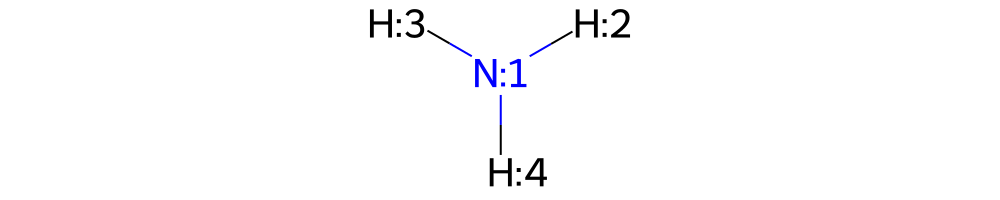

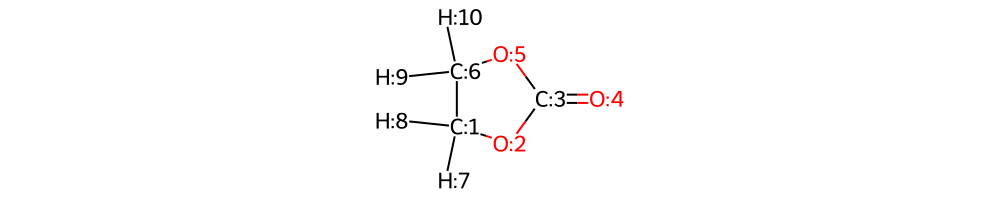

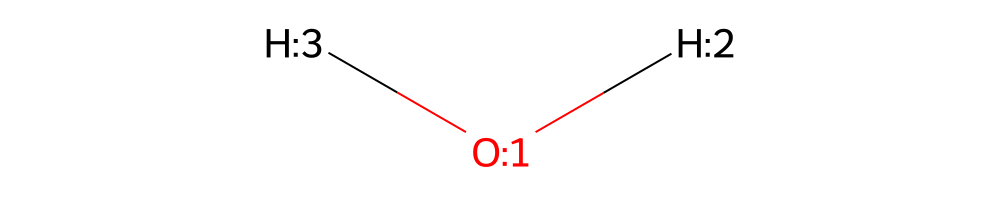

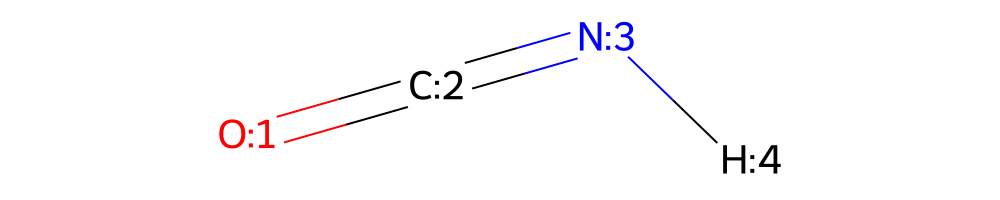

In [2]:
rdkdraw.set_rdkdraw_size(200, 5)

fn_group_smiles_base = {
    'amine'          : '[NH3]',
    'cyclocarbonate' : 'C1OC(=O)OC1',
    'hydroxyl'       : '[OH2]',
    'isocyanate'     : 'O=C=N'
}

fn_group_smarts_portless = {}
for group_name, smiles in fn_group_smiles_base.items():
    rdmol = Chem.MolFromSmiles(smiles)
    rdmol = Chem.AddHs(rdmol)
    rdmol = rdlabels.assign_ordered_atom_map_nums(rdmol, in_place=False)
    display(rdmol)

    fn_group_smarts_portless[group_name] = Chem.MolToSmarts(rdmol)

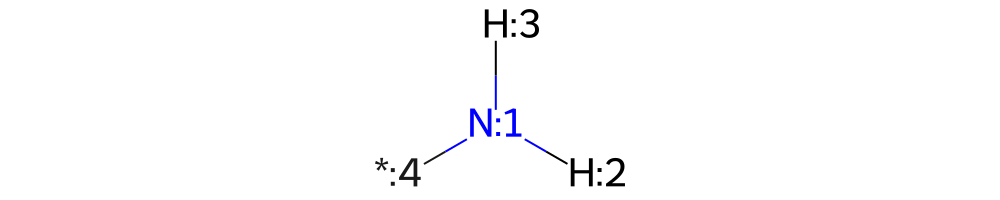

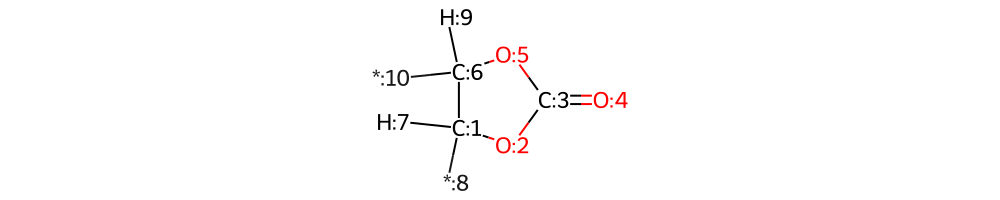

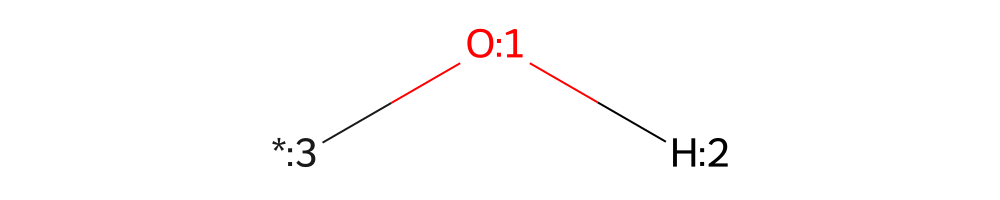

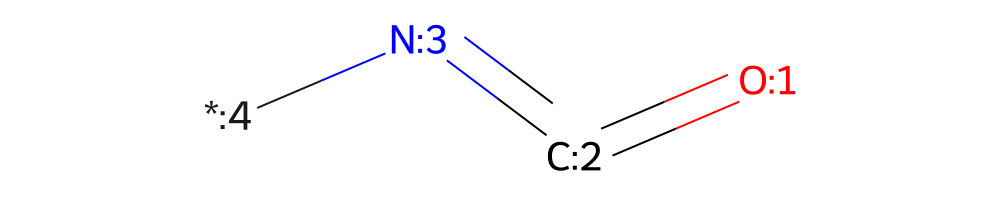

In [3]:
fn_group_smarts = { # add ports
    'amine'          : '[#7:1](-[#1:2])(-[#1:3])-[*:4]',
    'cyclocarbonate' : '[#6:1]1(-[#8:2]-[#6:3](=[#8:4])-[#8:5]-[#6:6]-1(-[#1:9])-[*:10])(-[#1:7])-[*:8]',
    'hydroxyl'       : '[#8:1](-[#1:2])-[*:3]',
    'isocyanate'     : '[#8:1]=[#6:2]=[#7:3]-[*:4]'
}

with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smarts, file, indent=4)

fn_groups = {}
for group, smarts in fn_group_smarts.items():
    group_mol = Chem.MolFromSmarts(smarts)
    display(group_mol)
    fn_groups[group] = group_mol

# Defining polymerization reactions

In [4]:
rdkdraw.set_rdkdraw_size(400, 3/2)
rxns, rxn_smarts = {}, {}

## NIPU reaction

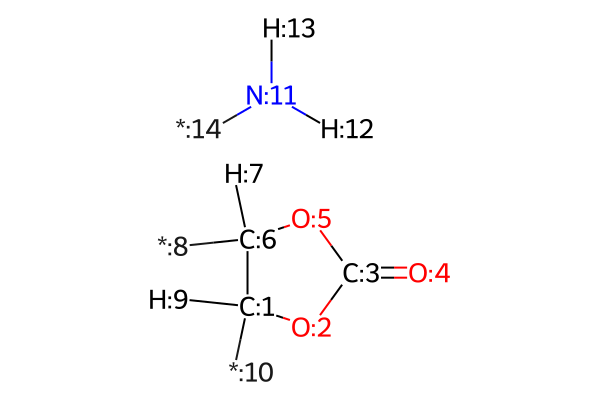

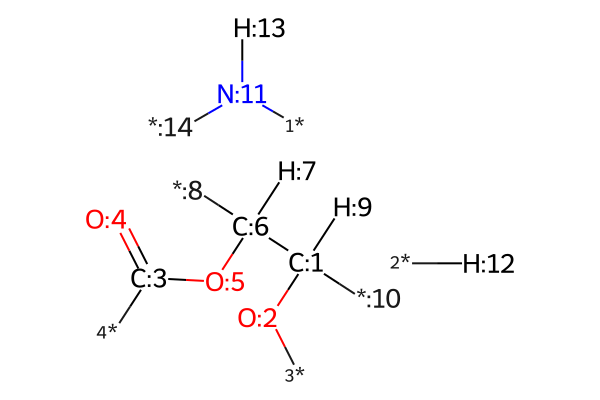

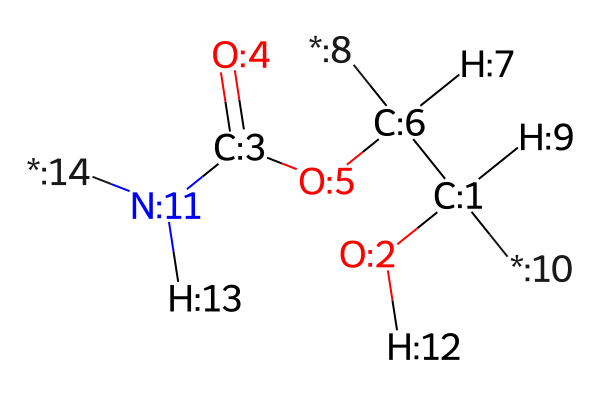

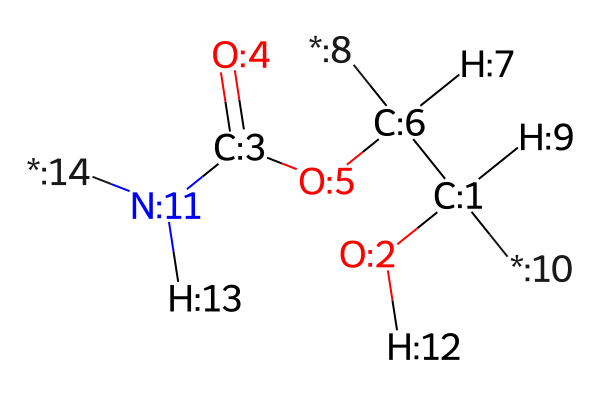

In [5]:
# 1) extracting and labelling reactants
reactant1, reactant2 = rdlabels.assign_contiguous_atom_map_nums(fn_groups['cyclocarbonate'], fn_groups['amine'], in_place=False)
reactant1_SMARTS = Chem.MolToSmarts(reactant1) 
reactant2_SMARTS = Chem.MolToSmarts(reactant2) 
reactants = Chem.MolFromSmarts(f'{reactant1_SMARTS}.{reactant2_SMARTS}')
display(reactants)

# 2) cleaving broken bonds
product = Chem.RWMol(reactants) # create editable Mol
bond_break_map_nums = ( # defining bonds to break my atom map num
    (11, 12),
    (2, 3)
)
for atom_pair in bond_break_map_nums:
    rdbond.decrease_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        dummyLabels=True,
        in_place=True
    )
display(product)

# 3) forming new bonds with cleaved groups
bond_make_map_nums = (
    (11, 3),
    (2, 12)
)
for atom_pair in bond_make_map_nums:
    rdbond.increase_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        prioritize_unlabelled_ports=True,
        in_place=True
    )
display(product)
    
# 4) delete ports created during bond breaking (!!important that this be done last!!)
rdlabels.clear_atom_isotopes(product, in_place=True)
display(product)

# defining reaction
rxn = reactions.AnnotatedReaction.from_rdmols(reactant_templates=[reactant1, reactant2], product_templates=[product])
rxns['NIPU'] = rxn
rxn_smarts['NIPU'] = rdChemReactions.ReactionToSmarts(rxn)

## Urethane reaction

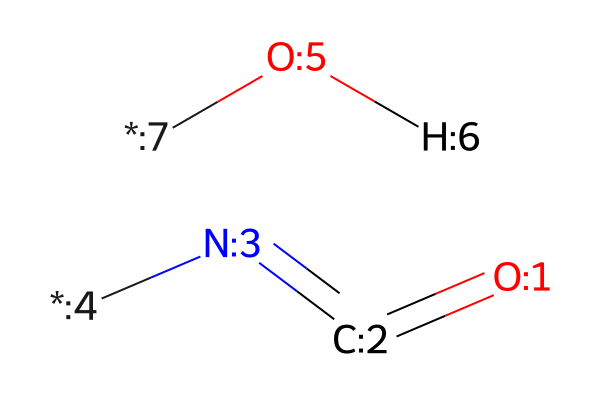

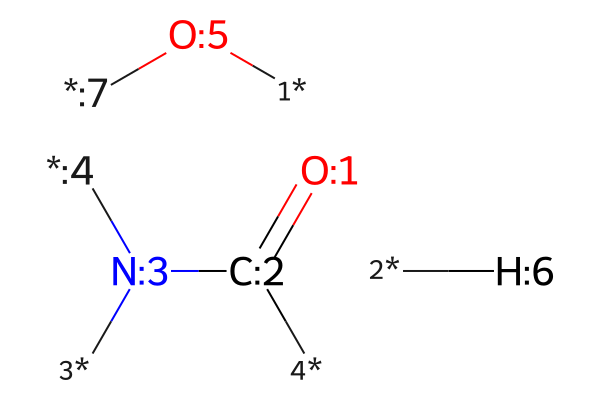

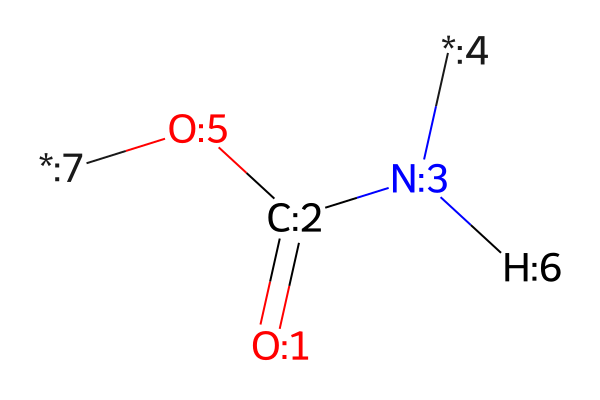

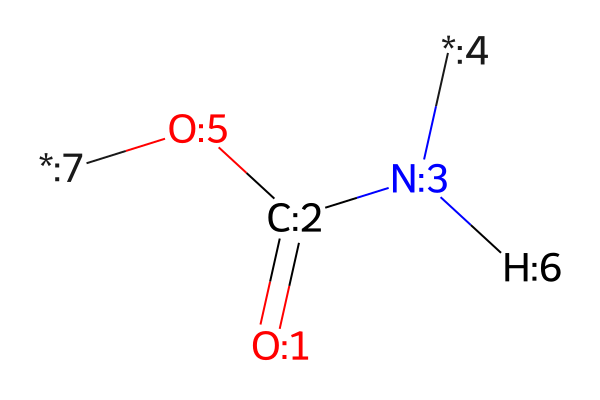

In [6]:
# 1) extracting and labelling reactants
reactant1, reactant2 = rdlabels.assign_contiguous_atom_map_nums(fn_groups['isocyanate'], fn_groups['hydroxyl'], in_place=False)
reactant1_SMARTS = Chem.MolToSmarts(reactant1) 
reactant2_SMARTS = Chem.MolToSmarts(reactant2) 
reactants = Chem.MolFromSmarts(f'{reactant1_SMARTS}.{reactant2_SMARTS}')
display(reactants)

# 2) cleaving broken bonds
product = Chem.RWMol(reactants) # create editable Mol
bond_break_map_nums = ( # defining bonds to break my atom map num
    (5, 6),
    (3, 2)
)
for atom_pair in bond_break_map_nums:
    rdbond.decrease_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        dummyLabels=True,
        in_place=True
    )
display(product)

# 3) forming new bonds with cleaved groups
bond_make_map_nums = (
    (3, 6),
    (5, 2)
)
for atom_pair in bond_make_map_nums:
    rdbond.increase_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        prioritize_unlabelled_ports=True,
        in_place=True
    )
display(product)
    
# 4) delete ports created during bond breaking (!!important that this be done last!!)
rdlabels.clear_atom_isotopes(product, in_place=True)
display(product)

# defining reaction
rxn = reactions.AnnotatedReaction.from_rdmols(reactant_templates=[reactant1, reactant2], product_templates=[product])
rxns['urethane'] = rxn
rxn_smarts['urethane'] = rdChemReactions.ReactionToSmarts(rxn)

## Saving SMARTS-based reaction equations to file

In [7]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)